In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import silhouette_samples, silhouette_score
from keras import callbacks
import tensorflow as tf
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv("cbb.csv")

In [3]:
df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


In [4]:
df.shape

(2455, 24)

In [5]:
df.dtypes

TEAM           object
CONF           object
G               int64
W               int64
ADJOE         float64
ADJDE         float64
BARTHAG       float64
EFG_O         float64
EFG_D         float64
TOR           float64
TORD          float64
ORB           float64
DRB           float64
FTR           float64
FTRD          float64
2P_O          float64
2P_D          float64
3P_O          float64
3P_D          float64
ADJ_T         float64
WAB           float64
POSTSEASON     object
SEED          float64
YEAR            int64
dtype: object

In [6]:
df.W.values

array([33, 36, 33, ..., 28, 24, 24], dtype=int64)

<AxesSubplot:xlabel='W', ylabel='count'>

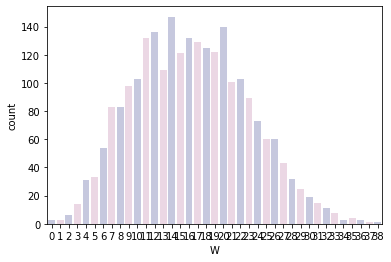

In [7]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= df["W"], palette= cols)

<AxesSubplot:>

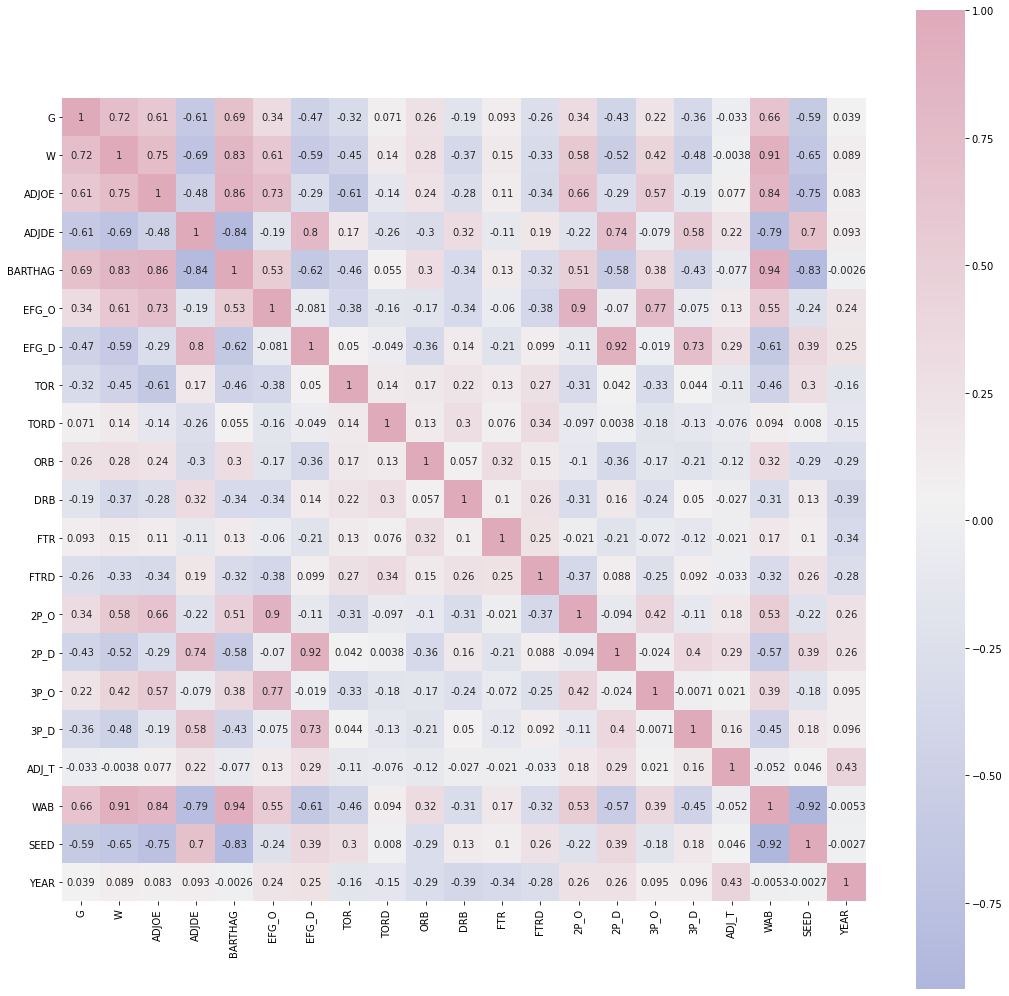

In [9]:
# Get list of categorical variables
s = (df.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['TEAM', 'CONF', 'POSTSEASON']


In [10]:
# Missing values in categorical variables

for i in object_cols:
    print(i, df[i].isnull().sum())

TEAM 0
CONF 0
POSTSEASON 1979


In [11]:
for i in object_cols:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [12]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    df[i] = label_encoder.fit_transform(df[i])
    
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TEAM        2455 non-null   int32  
 1   CONF        2455 non-null   int32  
 2   G           2455 non-null   int64  
 3   W           2455 non-null   int64  
 4   ADJOE       2455 non-null   float64
 5   ADJDE       2455 non-null   float64
 6   BARTHAG     2455 non-null   float64
 7   EFG_O       2455 non-null   float64
 8   EFG_D       2455 non-null   float64
 9   TOR         2455 non-null   float64
 10  TORD        2455 non-null   float64
 11  ORB         2455 non-null   float64
 12  DRB         2455 non-null   float64
 13  FTR         2455 non-null   float64
 14  FTRD        2455 non-null   float64
 15  2P_O        2455 non-null   float64
 16  2P_D        2455 non-null   float64
 17  3P_O        2455 non-null   float64
 18  3P_D        2455 non-null   float64
 19  ADJ_T       2455 non-null  

In [13]:
#clearing the dataset for accuracy
df.drop(columns = ['DRB','POSTSEASON','SEED', 'ORB'],inplace = True)
df.columns.values

array(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O',
       'EFG_D', 'TOR', 'TORD', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'YEAR'], dtype=object)

In [14]:
X = df.drop('W', axis=1)
y = df['W']

In [15]:
# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (1964, 19), X_test size: (491, 19)


In [16]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [17]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [21]:
# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 60, kernel_initializer = 'uniform',use_bias = 'true', activation = 'relu', input_dim = 19))
model.add(Dense(units = 60, kernel_initializer = 'uniform' ,use_bias = 'true', activation = 'relu'))
model.add(Dense(units = 60, kernel_initializer = 'uniform' ,use_bias = 'true', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform',use_bias = 'true', activation = 'sigmoid'))

In [22]:
# Compiling the ANN
opt = Adam()
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
# Train the ANN
history = model.fit(X_train, y_train, batch_size=500, validation_split=0.36, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
3/3 [==============================] - 1s 62ms/step - loss: 0.6405 - accuracy: 0.0000e+00 - val_loss: 0.5220 - val_accuracy: 0.0028
Epoch 2/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.4559 - accuracy: 0.0000e+00 - val_loss: 0.2849 - val_accuracy: 0.0028
Epoch 3/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.1780 - accuracy: 0.0000e+00 - val_loss: -0.0875 - val_accuracy: 0.0028
Epoch 4/1000
3/3 [==============================] - 0s 11ms/step - loss: -0.2634 - accuracy: 0.0000e+00 - val_loss: -0.6776 - val_accuracy: 0.0028
Epoch 5/1000
3/3 [==============================] - 0s 12ms/step - loss: -0.9744 - accuracy: 0.0000e+00 - val_loss: -1.5991 - val_accuracy: 0.0028
Epoch 6/1000
3/3 [==============================] - 0s 11ms/step - loss: -2.0716 - accuracy: 0.0000e+00 - val_loss: -3.0119 - val_accuracy: 0.0028
Epoch 7/1000
3/3 [==============================] - 0s 11ms/step - loss: -3.7427 - accuracy: 0.0000e+00 - val_loss: -5.1378

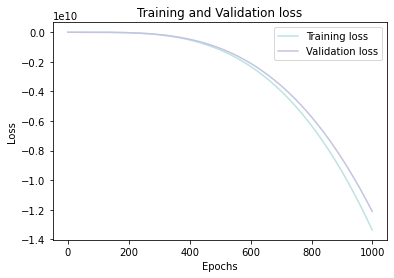

In [24]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

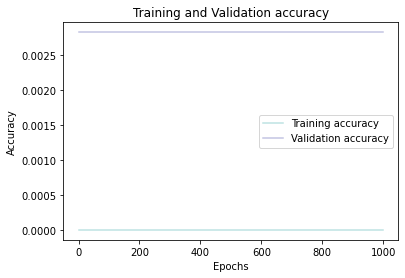

In [25]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [27]:
y_pred = (y_pred > 0.5)
y_pred

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

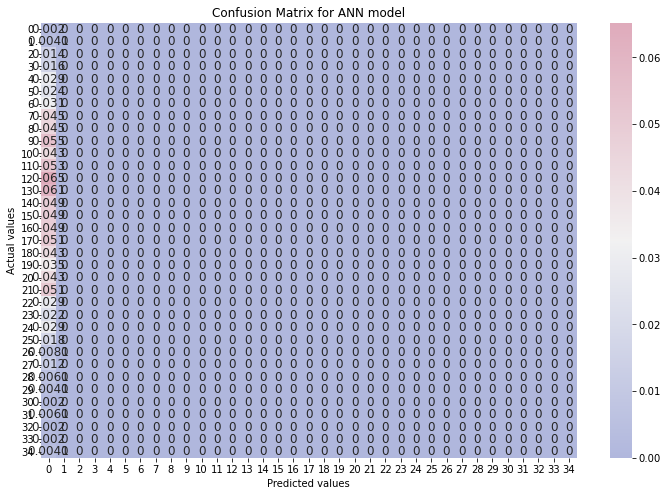

In [28]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':12})
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for ANN model')
plt.show()

In [29]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is: {}%'.format(score*100))

The accuracy for ANN model is: 0.20366598778004072%


In [30]:
df.drop(columns = ['WAB'],inplace = True)

In [31]:
df_clus_scaled= pd.DataFrame(sc.transform(df),columns = df.columns)
df_clus_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
TEAM,2455.0,0.017090,1.009806,-1.734508,-0.857832,0.018843,0.895518,1.752493
CONF,2455.0,0.004119,0.993194,-1.607361,-0.920149,0.159756,0.846969,1.730528
G,2455.0,-0.001507,1.008188,-6.258561,-0.567731,-0.188342,0.570435,3.226156
W,2455.0,-11.896427,0.903320,-14.121512,-12.618475,-11.935276,-11.252077,-8.929201
ADJOE,2455.0,-0.003971,1.119456,-4.056372,-0.763401,-0.050176,0.708573,3.910495
ADJDE,2455.0,401.453348,25.792535,326.072477,382.692271,402.216338,419.397517,482.265012
BARTHAG,2455.0,-15.914031,0.082672,-16.071783,-15.982350,-15.920147,-15.843620,-15.755865
EFG_O,2455.0,-0.077872,1.069371,-3.686081,-0.777095,-0.113642,0.634869,3.322704
EFG_D,2455.0,15.055791,1.415627,10.046786,14.091982,15.055124,16.018266,19.630048
TOR,2455.0,0.044024,0.957214,-3.098341,-0.625860,0.015153,0.656167,3.861235


In [32]:
sil_score = []
sil_width_min = []
for i in range(2,11):
    k_means = KMeans(n_clusters = i,random_state = 123)
    k_means.fit(df_clus_scaled)
    labels = k_means.labels_
    score = silhouette_score(df_clus_scaled,labels, random_state = 123)
    sil_score.append(score)
    print(f"The Silhouette Score of {i} clusters : {score}")
    min_width = silhouette_samples(df_clus_scaled,labels).min()
    sil_width_min.append(min_width)
    print(f"The Silhouette Width of {i} clusters : {min_width}")

The Silhouette Score of 2 clusters : 0.533135366391424
The Silhouette Width of 2 clusters : 0.0007891822776356713
The Silhouette Score of 3 clusters : 0.47972940961099697
The Silhouette Width of 3 clusters : -0.004613127527139974
The Silhouette Score of 4 clusters : 0.4479274480190341
The Silhouette Width of 4 clusters : -0.025734266144641322
The Silhouette Score of 5 clusters : 0.4254414757019735
The Silhouette Width of 5 clusters : -0.03535244557587057
The Silhouette Score of 6 clusters : 0.4120807832546772
The Silhouette Width of 6 clusters : -0.018464672236410906
The Silhouette Score of 7 clusters : 0.391580818761546
The Silhouette Width of 7 clusters : -0.014747480987389082
The Silhouette Score of 8 clusters : 0.3674008454676741
The Silhouette Width of 8 clusters : -0.009809170633763329
The Silhouette Score of 9 clusters : 0.338112504084723
The Silhouette Width of 9 clusters : -0.039122798080991894
The Silhouette Score of 10 clusters : 0.32695736793011865
The Silhouette Width of 1

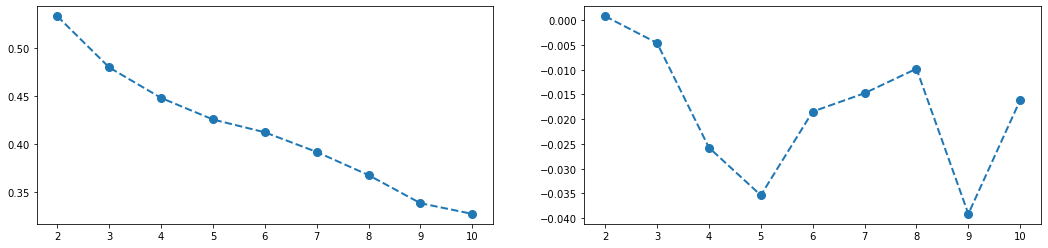

In [33]:
plt.figure(figsize = (18,4))
plt.subplot(1,2,1)
plt.plot(range(2,11),sil_score, marker='o', linestyle='dashed',linewidth=2, markersize=8);
plt.subplot(1,2,2)
plt.plot(range(2,11),sil_width_min, marker='o', linestyle='dashed',linewidth=2, markersize=8);

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

In [35]:
nn= MLPRegressor(hidden_layer_sizes=(10,10,), activation='logistic', max_iter=10)

In [36]:
nn.fit(X_train,y_train)

C:\Users\David Nereekshan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=(10, 10), max_iter=10)

In [37]:
mae=metrics.mean_absolute_error(y_train, nn.predict(X_train))
mse=metrics.mean_squared_error(y_train, nn.predict(X_train))
rsq=metrics.r2_score(y_train, nn.predict(X_train))
print(mae, mse, rsq)

16.357951388701135 310.3355502933016 -6.128682107026991


In [38]:
mae1=metrics.mean_absolute_error(y_test, nn.predict(X_test))
mse1=metrics.mean_squared_error(y_test, nn.predict(X_test))
rsq1=metrics.r2_score(y_test, nn.predict(X_test))
print(mae1, mse1, rsq1)

16.381254726744523 311.8415144007631 -6.039155168511154
